In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Validation/F/167.jpg  
  inflating: dataset/Validation/F/168.jpg  
  inflating: dataset/Validation/F/169.jpg  
  inflating: dataset/Validation/F/17.jpg  
  inflating: dataset/Validation/F/170.jpg  
  inflating: dataset/Validation/F/171.jpg  
  inflating: dataset/Validation/F/172.jpg  
  inflating: dataset/Validation/F/173.jpg  
  inflating: dataset/Validation/F/174.jpg  
  inflating: dataset/Validation/F/175.jpg  
  inflating: dataset/Validation/F/176.jpg  
  inflating: dataset/Validation/F/177.jpg  
  inflating: dataset/Validation/F/178.jpg  
  inflating: dataset/Validation/F/179.jpg  
  inflating: dataset/Validation/F/18.jpg  
  inflating: dataset/Validation/F/180.jpg  
  inflating: dataset/Validation/F/181.jpg  
  inflating: dataset/Validation/F/182.jpg  
  inflating: dataset/Validation/F/183.jpg  
  inflating: dataset/Validation/F/184.jpg  
  inflating: dataset/Validation/F/185.jpg  
  inflating: dataset/Valida

In [3]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import tqdm
import IPython

In [4]:
train_directory = '../content/dataset/Train' 
val_directory = '../content/dataset/Validation'

In [5]:
def set_device():

  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("cpu!")
  else:
    print("GPU")

  return device
DEVICE = set_device()

GPU


In [6]:
# Prepare train and test dataloader
transform_image = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] )
    ])
Batch_size = 256
train_data = torchvision.datasets.ImageFolder(root=train_directory, transform=transform_image)
train_data_loader = data.DataLoader(train_data, batch_size=Batch_size, shuffle=True,  num_workers=0)
test_data = torchvision.datasets.ImageFolder(root=val_directory, transform=transform_image)
test_data_loader  = data.DataLoader(test_data, batch_size=Batch_size, shuffle=True, num_workers=0) 

**transfer learning using resnet**

In [7]:
# Determine number of classes
# we have 39 kind of charrecters
num_classes = 39

In [8]:
from torchvision.models.resnet import resnet50
base = torchvision.models.resnet50(pretrained=True)
#  nuber of filters from the lasr layer of the pretrained model
num_filters = base.fc.in_features
# Reset final fully connected layer, number of classes = 39
base.fc = nn.Linear(num_filters, num_classes)
base.to(DEVICE)
# set optimizer
optimizer = torch.optim.NAdam(base.parameters(), lr=.0004)
# loss
lossfunc = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

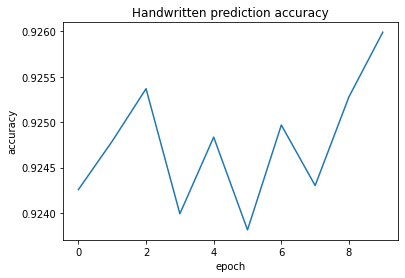

100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


In [11]:
pretrained_accuracy = []
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
  
  nsamples = [] * 650000
  # Train loop
  for batch in train_data_loader:
    # spliting dataset 
    if batch > nsamples:
      break
    
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = base(images)
    loss = lossfunc(output, labels)
    loss.backward()
    optimizer.step()

 # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(test_data)
    for batch in test_data_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = base(images)
      loss = lossfunc(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct 

    # Plot accuracy
    pretrained_accuracy.append(total_correct.cpu() / total)
    plt.plot(pretrained_accuracy)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Handwritten prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()  